According to Wikipedia, the "Big Five personality traits, also known as the five-factor model (FFM) and the OCEAN model, is a taxonomy, or grouping, for personality traits. When factor analysis [...] is applied to personality survey data, some words used to describe aspects of personality are often applied to the same person. For example, someone described as conscientious is more likely to be described as "always prepared" rather than "messy". This theory is based therefore on the association between words but not on neuropsychological experiments. This theory uses descriptors of common language and therefore suggests five broad dimensions commonly used to describe the human personality and psyche."

Those five dimensions are:
- **Openness to experience** (how inventive/curious one is)
- **Conscientiousness** (how efficient/organised/industrious one is)
- **Extraversion** (how outgoing/energetic/exhibiting-positive-emotion one is)
- **Agreeableness** (how conflict-aversive/friendly/compassionate one is)
- **Neuroticism** (how prone to negative emotions one is)

The dataset that will be used in this exploration includes >1 million questionnaire answers collected by [Open Psychometrics](https://openpsychometrics.org/tests/IPIP-BFFM/). **It should be interesting to see if we can come up with some robust personality archetypes based on the Big Five model**.

In [1]:
# Importing libraries:  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from statistics import median

In [2]:
# %load_ext pycodestyle_magic

In [3]:
# %pycodestyle_on

In [4]:
# Reading and peeking at data:  
df = pd.read_csv('../personality_data/data-final.csv', delimiter='\t')
df.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [5]:
# Looking at column names:  
column_names = df.columns.tolist()
column_names

['EXT1',
 'EXT2',
 'EXT3',
 'EXT4',
 'EXT5',
 'EXT6',
 'EXT7',
 'EXT8',
 'EXT9',
 'EXT10',
 'EST1',
 'EST2',
 'EST3',
 'EST4',
 'EST5',
 'EST6',
 'EST7',
 'EST8',
 'EST9',
 'EST10',
 'AGR1',
 'AGR2',
 'AGR3',
 'AGR4',
 'AGR5',
 'AGR6',
 'AGR7',
 'AGR8',
 'AGR9',
 'AGR10',
 'CSN1',
 'CSN2',
 'CSN3',
 'CSN4',
 'CSN5',
 'CSN6',
 'CSN7',
 'CSN8',
 'CSN9',
 'CSN10',
 'OPN1',
 'OPN2',
 'OPN3',
 'OPN4',
 'OPN5',
 'OPN6',
 'OPN7',
 'OPN8',
 'OPN9',
 'OPN10',
 'EXT1_E',
 'EXT2_E',
 'EXT3_E',
 'EXT4_E',
 'EXT5_E',
 'EXT6_E',
 'EXT7_E',
 'EXT8_E',
 'EXT9_E',
 'EXT10_E',
 'EST1_E',
 'EST2_E',
 'EST3_E',
 'EST4_E',
 'EST5_E',
 'EST6_E',
 'EST7_E',
 'EST8_E',
 'EST9_E',
 'EST10_E',
 'AGR1_E',
 'AGR2_E',
 'AGR3_E',
 'AGR4_E',
 'AGR5_E',
 'AGR6_E',
 'AGR7_E',
 'AGR8_E',
 'AGR9_E',
 'AGR10_E',
 'CSN1_E',
 'CSN2_E',
 'CSN3_E',
 'CSN4_E',
 'CSN5_E',
 'CSN6_E',
 'CSN7_E',
 'CSN8_E',
 'CSN9_E',
 'CSN10_E',
 'OPN1_E',
 'OPN2_E',
 'OPN3_E',
 'OPN4_E',
 'OPN5_E',
 'OPN6_E',
 'OPN7_E',
 'OPN8_E',
 'OPN9_E',
 '

According to the notes accompanying the dataset, the columns correspond to questionnaire questions/statements. For example the statement with code EXT1 belongs to the extraversion category (hence "EXT") and is "I am the life of the party.". The possible answers are "disagree" (yielding 1 point), "neutral" (yielding 3 points) and "agree" (yielding 5 points). The higher the "score" in this question, the more extraverted the questionnaire-taker is considered to be. Other questions involve the inverse of this relationship. For example, EXT2 is "I don't talk a lot.". The score obtained in this question would need to be subtracted when calculating the overall extraversion result. Neuroticism questions are the "EST" ones (not sure why "EST" and not "NEU", but anyway), agreeableness ones are "AGR", conscientiousness "CSN" and openness to experience "OPN".

The column names ending in "E" indicate the time the user took to answer the corresponding question. A shorter response time could be associated with higher certainty about the answer, so it might be useful to be taken into account when drawing insights from the data.

The rest of the columns are mostly self-explanatory and might be explained in more detail where appropriate later on.

In [6]:
# Looking at some descriptive statistics:  
df.describe()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,...,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,...,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013275e+06,1.013275e+06,1.013275e+06,1.013558e+06,1.015341e+06,1.015341e+06
mean,2.648067e+00,2.773115e+00,3.288349e+00,3.140595e+00,3.276960e+00,2.401100e+00,2.771744e+00,3.414818e+00,2.963740e+00,3.556469e+00,...,7.689488e+03,5.423945e+03,6.325802e+03,5.336311e+03,1.149510e+03,8.262611e+02,9.590748e+02,6.754233e+02,2.701410e+03,1.045211e+01
std,1.264407e+00,1.323943e+00,1.215006e+00,1.237442e+00,1.277593e+00,1.225721e+00,1.400336e+00,1.271915e+00,1.346040e+00,1.305232e+00,...,5.841987e+05,2.629748e+05,4.298906e+05,4.408225e+05,5.600884e+02,1.802490e+02,5.104005e+04,2.017864e+04,1.483898e+06,3.982879e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-6.181300e+04,-5.001200e+04,-9.598600e+04,-3.594871e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,...,2.279000e+03,2.144000e+03,2.329000e+03,1.484000e+03,4.140000e+02,7.200000e+02,5.000000e+00,1.710000e+02,9.000000e+00,1.000000e+00
50%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,...,3.208000e+03,3.051000e+03,3.269000e+03,2.192000e+03,1.366000e+03,7.680000e+02,1.000000e+01,2.240000e+02,1.300000e+01,1.000000e+00
75%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,...,4.729000e+03,4.469000e+03,4.785000e+03,3.362000e+03,1.440000e+03,9.000000e+02,3.000000e+01,3.130000e+02,1.800000e+01,2.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,3.891434e+08,1.696693e+08,3.470326e+08,3.344289e+08,1.366000e+04,8.802000e+03,2.944307e+07,1.189272e+07,1.493327e+09,7.250000e+02


One question that quickly comes to mind is "is there anything interesting about the average questionnaire taker (in terms of how they answered)?":

In [7]:
# Grouping columns by personality trait:  
ext_cols = column_names[:10]
est_cols = column_names[10:20]
agr_cols = column_names[20:30]
csn_cols = column_names[30:40]
opn_cols = column_names[40:50]

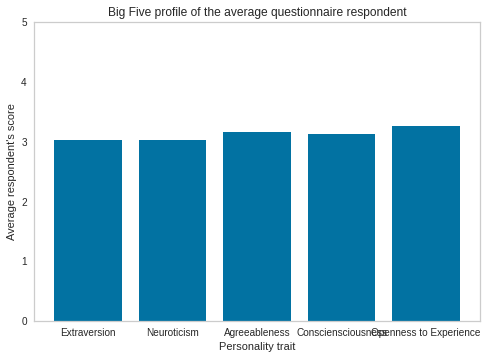

In [8]:
# Getting the mean "score" for each personality trait and visualising them:   
ext_mean = df[ext_cols].mean().mean()
est_mean = df[est_cols].mean().mean()
agr_mean = df[agr_cols].mean().mean()
csn_mean = df[csn_cols].mean().mean()
opn_mean = df[opn_cols].mean().mean()
trait_means = [ext_mean, est_mean, agr_mean, csn_mean, opn_mean]
traits = ['Extraversion', 'Neuroticism', 'Agreeableness', 'Consciensciousness',
          'Openness to Experience']

ax = plt.subplot()
ax.bar(traits, trait_means)
ax.set_xlabel('Personality trait')
ax.set_ylabel("Average respondent's score")
ax.set_title('Big Five profile of the average questionnaire respondent')
ax.grid()
ax.set_ylim([0, 5])
plt.show()

As expected, everything is around 3 ("neutral"), though openness has an edge, followed by agreeableness and conscientiousness. Would be interesting to see if that deviation is statistically significant as well as how this overall patterns relates to the way people tend to respond to such a questionnaire.

But let us not go down that rabbit hole now and let us resume data exploration, starting by checking for any null values in the data.

In [9]:
# Get number of null values in each column:  
null_counts = df.isnull().sum()
# Sort columns that have null values by number of null values in desc. order:
null_counts[null_counts > 0].sort_values(ascending=False)

introelapse    2066
screenh        2066
screenw        2066
EXT1           1783
EST6_E         1783
               ... 
CSN3           1783
CSN2           1783
CSN1           1783
AGR10          1783
country          77
Length: 105, dtype: int64

In [10]:
# View them as percentages of total values:  
null_percentages = null_counts*100/len(df)
null_percentages[null_percentages > 0].sort_values(ascending=False)

introelapse    0.203478
screenh        0.203478
screenw        0.203478
EXT1           0.175606
EST6_E         0.175606
                 ...   
CSN3           0.175606
CSN2           0.175606
CSN1           0.175606
AGR10          0.175606
country        0.007584
Length: 105, dtype: float64

This obviously gives a clearer picture. The highest prevalence of null values in a column is 0.2%, which could be considered insignificant. The manner in which we'll deal with those values is by replacing them with the corresponding column means, where appropriate.

In accordance with our initial inspiration for playing with this dataset (to see if we can come up with some personality archetypes), let us focus on the question columns for now.

In [11]:
q_df = df[df.columns[:50]]

In [12]:
# Get number of null values in each column:  
null_counts = q_df.isnull().sum()

# Sort columns that have null values by number of null values in desc. order:  
null_counts[null_counts > 0].sort_values(ascending=False)

EXT1     1783
CSN8     1783
AGR8     1783
AGR9     1783
AGR10    1783
CSN1     1783
CSN2     1783
CSN3     1783
CSN4     1783
CSN5     1783
CSN6     1783
CSN7     1783
CSN9     1783
EXT2     1783
CSN10    1783
OPN1     1783
OPN2     1783
OPN3     1783
OPN4     1783
OPN5     1783
OPN6     1783
OPN7     1783
OPN8     1783
OPN9     1783
AGR7     1783
AGR6     1783
AGR5     1783
AGR4     1783
EXT3     1783
EXT4     1783
EXT5     1783
EXT6     1783
EXT7     1783
EXT8     1783
EXT9     1783
EXT10    1783
EST1     1783
EST2     1783
EST3     1783
EST4     1783
EST5     1783
EST6     1783
EST7     1783
EST8     1783
EST9     1783
EST10    1783
AGR1     1783
AGR2     1783
AGR3     1783
OPN10    1783
dtype: int64

In [13]:
q_df.fillna(value=q_df.mean(), inplace=True)

/home/charis/anaconda3/envs/personality/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


To determine a good potential number of archetypes (clusters), we will use the elbow method. Typically, the more clusters, the smaller the differences between clusters and the bigger the differences within clusters. We'd like to find a balance, where the differences between clusters are as big as possible while the differences within clusters are as small as possible. The latter measure is represented by the within-cluster sum of squares (WCSS).

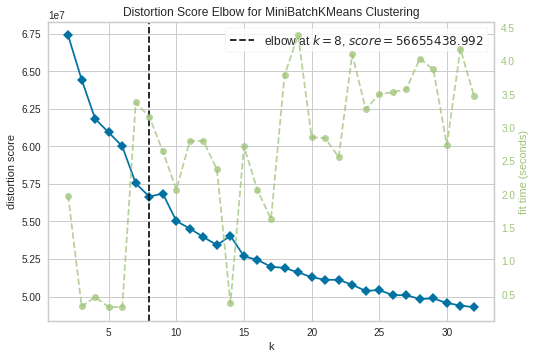

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
kmeans = MiniBatchKMeans(batch_size=100)
'''
If we were to assume that an individual is either considered to be high or low 
in each of the five traits, then the number of trait combinations (essentially 
archetypes) would be 2^5 = 32. Since 32 is definitely in the upper range of the 
number of personality archetypes that one would consider intuitively sensible, 
we'll use it as our higher end in determining the optimal number of clusters.
'''
viz = KElbowVisualizer(kmeans, k=(2, 33))
viz.fit(q_df)
viz.poof()

In [16]:
'''
Based on the elbow's appearance, as well as intuition about a sensible number 
of archetypes, we'll choose k = 12:
'''
k = 12
kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100, 
                         max_iter=100).fit(q_df)
kmeans.fit(q_df)
centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

In [17]:
types = {}

for i in range(k):
    types[f'type_{i+1}'] = kmeans.cluster_centers_[i]
    
types

{'type_1': array([1.99815962, 3.57404454, 2.72974051, 3.63999141, 2.55475124,
        2.77482977, 1.96297773, 3.82126863, 2.65787375, 4.04944482,
        2.21584565, 3.72661186, 2.99368137, 3.25072081, 2.15535857,
        1.88862646, 2.07063984, 1.6816453 , 2.65382492, 2.05830931,
        3.31798663, 2.7001411 , 2.65284338, 2.44399117, 3.63302865,
        2.33675848, 3.46555426, 2.76599595, 2.34758604, 3.02094963,
        4.00291393, 2.08471873, 4.2829581 , 1.75909453, 3.19698178,
        1.91647752, 4.20112263, 1.99128888, 3.6367094 , 4.03211459,
        4.0580946 , 1.69320901, 3.8722471 , 1.91337955, 4.1013128 ,
        1.92049568, 4.40098767, 3.61395006, 4.08662045, 4.06876879]),
 'type_2': array([2.27635766, 3.04970678, 3.00123437, 3.5478949 , 3.09407408,
        2.5699305 , 2.3239812 , 3.85181487, 2.48345296, 4.08060809,
        4.15684551, 2.53909331, 4.5105521 , 2.32655923, 3.35577565,
        3.62514864, 3.65152063, 3.29234978, 3.75779576, 3.26768165,
        1.94422392, 3.9056

Reminder:
- Questions 1 through 10 measure extraversion
- Questions 11 through 20 measure neuroticism
- Questions 21 through 30 measure agreeableness
- Questions 31 through 40 measure conscientiousness
- Questions 41 through 50 measure neuroticism

In [18]:
all_types_scores = {}

for name, _type in types.items():
    trait = {}
    '''
    Adding/subtracting based on the questions' sentiments (see explanation 
    above):
    '''
    trait['Extraversion score'] =  _type[0] - _type[1] + _type[2] - _type[3] 
    + _type[4] - _type[5] + _type[6] - _type[7] + _type[8] - _type[9]
    trait['Neuroticism score'] =  _type[10] - _type[11] + _type[12]
    - _type[13] + _type[14] + _type[15] + _type[16] + _type[17] + _type[18]
    + _type[19]
    trait['Agreeableness score'] =  - _type[20] + _type[21] - _type[22] 
    + _type[23] - _type[24] - _type[25] + _type[26] - _type[27] + _type[28]
    + _type[29]
    trait['Conscientiousness score'] = _type[30] - _type[31] + _type[32]
    - _type[33] + _type[34] - _type[35] + _type[36] - _type[37] + _type[38]
    + _type[39]
    trait['Openness score'] =  _type[40] - _type[41] + _type[42] - _type[43]
    + _type[44] - _type[45] + _type[46] + _type[47] + _type[48] + _type[49]
    
    all_types_scores[name] = trait

In [19]:
all_types_scores

{'type_1': {'Extraversion score': -2.4861358198883554,
  'Neuroticism score': 1.4829151585792308,
  'Agreeableness score': -3.2706889147905005,
  'Conscientiousness score': 6.201153303478312,
  'Openness score': 4.323753143978934},
 'type_2': {'Extraversion score': -1.32000964738556,
  'Neuroticism score': 6.128304293593978,
  'Agreeableness score': 0.05393167671671373,
  'Conscientiousness score': 6.286856793400414,
  'Openness score': 3.2682976099099057},
 'type_3': {'Extraversion score': 0.39797913950456176,
  'Neuroticism score': 0.9964146023468003,
  'Agreeableness score': -0.65254237288135,
  'Conscientiousness score': 1.1564537157757522,
  'Openness score': 0.6016949152542356},
 'type_4': {'Extraversion score': 0.7962059301938265,
  'Neuroticism score': 1.5946067768044236,
  'Agreeableness score': -2.5654261469418236,
  'Conscientiousness score': 2.5531189370333207,
  'Openness score': 4.044447057440192},
 'type_5': {'Extraversion score': 0.9061407813917524,
  'Neuroticism score

We want each variable to have an equal impact on our analysis, so we'll normalise the data, transforming them to a [0, 1] range. The way to do so (for a variable x) is to divide x - x_min by x_max - x_min.

In [20]:
all_extraversion = []
all_neuroticism = []
all_agreeableness = []
all_conscientiousness = []
all_openness = []

for _type, trait in all_types_scores.items():
    all_extraversion.append(trait['Extraversion score'])
    all_neuroticism.append(trait['Neuroticism score'])
    all_agreeableness.append(trait['Agreeableness score'])
    all_conscientiousness.append(trait['Conscientiousness score'])
    all_openness.append(trait['Openness score'])

# TODO: figure out how to do this with a tool like MinMaxScaler   
    
all_extraversion_normalised = (all_extraversion-min(all_extraversion))\
/(max(all_extraversion)-min(all_extraversion))
all_neuroticism_normalised = (all_neuroticism-min(all_neuroticism))\
/(max(all_neuroticism)-min(all_neuroticism))
all_agreeableness_normalised = (all_agreeableness-min(all_agreeableness))\
/(max(all_agreeableness)-min(all_agreeableness))
all_conscientiousness_normalised = (all_conscientiousness-min(all_conscientiousness))\
/(max(all_conscientiousness)-min(all_conscientiousness))
all_openness_normalised = (all_openness-min(all_openness))\
/(max(all_openness)-min(all_openness))

Let's check one of the normalised personality dimensions out:

In [21]:
all_extraversion_normalised

array([0.25014643, 0.37110949, 0.54931764, 0.59062598, 0.6020296 ,
       0.28379817, 0.31770129, 0.        , 0.91040055, 0.14062166,
       1.        , 0.8892492 ])

In [22]:
all_types_scores_normalised = {}
counter = 0
for _type, trait in all_types_scores.items():
    normalised_traits = {}
    normalised_traits['Extraversion'] = all_extraversion_normalised[counter]
    normalised_traits['Neuroticism'] = all_neuroticism_normalised[counter]
    normalised_traits['Agreeableness'] = all_agreeableness_normalised[counter]
    normalised_traits['Conscientiousness'] = all_conscientiousness_normalised[counter]
    normalised_traits['Openness'] = all_openness_normalised[counter]
    
    all_types_scores_normalised[_type] = normalised_traits
    
    counter += 1

Let's see what each personality type's normalised scores look like (first in numerical format and then in bar charts):

In [23]:
all_types_scores_normalised

{'type_1': {'Extraversion': 0.25014642881367405,
  'Neuroticism': 0.09103150941561586,
  'Agreeableness': 0.0584305505951901,
  'Conscientiousness': 0.9832949792393736,
  'Openness': 0.7823089868305062},
 'type_2': {'Extraversion': 0.3711094929250831,
  'Neuroticism': 0.960253094809366,
  'Agreeableness': 0.7851938434884997,
  'Conscientiousness': 1.0,
  'Openness': 0.6046231352753912},
 'type_3': {'Extraversion': 0.549317642841874,
  'Neuroticism': 0.0,
  'Agreeableness': 0.6307583545364227,
  'Conscientiousness': 0.0,
  'Openness': 0.15570079296469344},
 'type_4': {'Extraversion': 0.590625979751627,
  'Neuroticism': 0.11193067687978296,
  'Agreeableness': 0.21260125290813764,
  'Conscientiousness': 0.27223303902745477,
  'Openness': 0.7352878303448012},
 'type_5': {'Extraversion': 0.6020295969305399,
  'Neuroticism': 0.24978453284860874,
  'Agreeableness': 0.935555968556169,
  'Conscientiousness': 0.9964316076919142,
  'Openness': 0.613516311859727},
 'type_6': {'Extraversion': 0.283

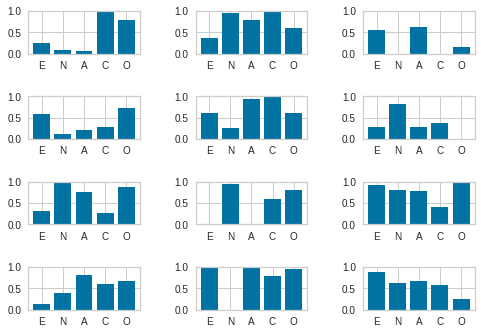

In [24]:
# Determining plotting grid dimensions by getting the divisors of k:  
divisors = []
for i in range(1, k+1):
    if k % i == 0:
        divisors.append(i)
mid = divisors[int((len(divisors) - 1) // 2)]
# TODO: fix this so that it works when k is odd
n_rows = int(k / mid)
n_cols = int(k / n_rows)
        
    
# Plotting:  
fig, axes = plt.subplots(n_rows, n_cols)

x = ['E', 'N', 'A', 'C', 'O']
# TODO: make plots prettier and more understandable
plot_count = 0
for i in range(n_rows):
    for j in range(n_cols):
        plot_count += 1    
        axes[i, j].bar(x,
                       all_types_scores_normalised[f'type_{plot_count}'].values())
        axes[i, j].set_ylim(0, 1)

plt.subplots_adjust(wspace=0.5, hspace=1)

plt.show()

At first sight, we seem to be getting decent clusters/archetypes. Although not all possible combinations of traits are included (otherwise we'd end up with at least 32 archetypes, depending on how thorough we'd like them to be, which would be practically pointless), we are definitely getting a sense of "archetypes".

Personally, I happen to have taken a Big Five test in the past, and, based on my results, the archetype that seems to be the closest fit (though with a fair amount of deviation) is type 1.

More work would be needed to make this model more robust, so this will be left open-ended for now. I definitely think that coming up with archetypes like these, which would include thorough descriptions of the personalities that they generally represent (along with smart descriptive names, like the Myers-Briggs model uses, such as "The Architect", "The Mediator", "The Entertainer" etc.), could lead to a somewhat reliable, practical and understandable model (technically an interpretation tool for Big Five results) that could be used in various contexts.

This was a sort of "speed run" through the data. I will probably come back to this in the future, further exploring and refining.